In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_216.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_98.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_137.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_86_1.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_19_1.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_202.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_159.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_217.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_185_1.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_40_1.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_107.mp4
/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifter

# **1. Install & Import**

In [2]:
!pip install pytorchvideo torchmetrics rich plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.0 MB/s eta 0:00:0000:0100:01
   ━

In [39]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from rich.console import Console
from moviepy.editor import VideoFileClip
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import pytorchvideo.models.resnet as resnet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go
import time
from plotly.subplots import make_subplots

In [4]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
from rich.console import Console
from rich.panel import Panel
from torchinfo import summary
import torch
import torch.nn as nn
import numpy as np
import cv2
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

In [5]:
console = Console()

# **2. Preprocessing (video → clips)**

In [6]:
DATA_DIR = "/kaggle/input/anti-theft-dataset/Shop DataSet"
CLASSES = ["non shop lifters", "shop lifters"]
FRAME_SIZE = (112, 112)  # resize for pretrained R3D
FRAMES_PER_CLIP = 16
BATCH_SIZE = 8

In [7]:
class VideoClipsDataset(Dataset):
    def __init__(self, video_paths, labels, frames_per_clip=FRAMES_PER_CLIP, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.frames_per_clip = frames_per_clip
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def read_video_frames(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start = random.randint(0, max(0, total_frames - self.frames_per_clip))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        for _ in range(self.frames_per_clip):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        cap.release()
        return np.array(frames)

    def __getitem__(self, idx):
        video = self.read_video_frames(self.video_paths[idx])
        label = self.labels[idx]

        if self.transform:
            video = torch.stack([self.transform(frame) for frame in video])
        video = video.permute(1, 0, 2, 3)  # (C, T, H, W)
        return video.float(), label

In [8]:
def load_dataset(data_dir, classes):
    video_paths, labels = [], []
    for i, cls in enumerate(classes):
        class_dir = f"{data_dir}/{cls}"
        for f in os.listdir(class_dir):
            if f.endswith((".mp4", ".avi")):
                video_paths.append(f"{class_dir}/{f}")
                labels.append(i)
    return video_paths, labels

In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(FRAME_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])


In [10]:
video_paths, labels = load_dataset(DATA_DIR, CLASSES)

In [11]:
# =============================
# Split Data
# =============================
train_paths, test_paths, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# =============================
# Create Datasets
# =============================
train_ds = VideoClipsDataset(train_paths, train_labels, FRAMES_PER_CLIP, transform=train_transform)
val_ds = VideoClipsDataset(val_paths, val_labels, FRAMES_PER_CLIP, transform=test_transform)
test_ds = VideoClipsDataset(test_paths, test_labels, FRAMES_PER_CLIP, transform=test_transform)

In [12]:
# =============================
# Create DataLoaders
# =============================
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

console.print(Panel.fit(f"[bold green]Train videos:[/bold green] {len(train_ds)}\n"
                        f"[bold cyan]Validation videos:[/bold cyan] {len(val_ds)}\n"
                        f"[bold magenta]Test videos:[/bold magenta] {len(test_ds)}",
                        title="[bold yellow]Dataset Summary[/bold yellow]", border_style="bright_blue"))


╭─── Dataset Summary ────╮
│ Train videos: 547      │
│ Validation videos: 137 │
│ Test videos: 171       │
╰────────────────────────╯

In [13]:
# train_paths, val_paths, train_labels, val_labels = train_test_split(video_paths, labels, test_size=0.2, stratify=labels)

# train_ds = VideoClipsDataset(train_paths, train_labels, FRAMES_PER_CLIP, transform)
# val_ds = VideoClipsDataset(val_paths, val_labels, FRAMES_PER_CLIP, transform)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# console.print(f"[bold green]Train videos:[/bold green] {len(train_ds)}, [bold cyan]Val videos:[/bold cyan] {len(val_ds)}")

# **3. Pretrained Model (R3D_18)**

In [19]:
def build_pretrained_r3d18(num_classes=2, device=None):
    """
    Build a pretrained R3D-18 model for video classification.
    
    Parameters:
        num_classes (int): Number of output classes.
        device (torch.device or None): Device to move the model to.
        
    Returns:
        model (nn.Module): Modified R3D-18 model.
    """
    console.print(Panel("[bold cyan]Building Pretrained R3D-18 Model[/bold cyan]", expand=False))

    # Load pretrained R3D-18
    model = r3d_18(pretrained=True)

    # Replace the final FC layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Move model to device if provided
    if device:
        model = model.to(device)
        console.print(f"✅ Model moved to device: [bold yellow]{device}[/bold yellow]")

    # Print model summary
    console.print(Panel("[bold green]Model Summary[/bold green]", expand=False))
    summary(model, input_size=(1, 3, 16, 112, 112))  # Example: batch=1, 16 frames, 112x112

    console.print(Panel("[bold magenta]R3D-18 model ready for training![/bold magenta]", expand=False))
    return model

# **4. Training & Evaluation**

In [20]:
def calculate_metrics(y_true, y_pred):
    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    )

In [31]:
def plot_history(history, save_path="training_curves.html"):
    """
    Plot training metrics (loss, accuracy, precision, recall, F1) for both training and validation
    in separate subplots using Plotly, and save as interactive HTML.
    
    Args:
        history (dict): Dictionary containing training and validation metrics.
        save_path (str): Path to save the interactive HTML plot.
    """
    console.print(Panel("[bold magenta]📊 Plotting Training Metrics[/bold magenta]", expand=False))

    metrics = ["loss", "accuracy", "precision", "recall", "f1"]
    colors = {"train": "cyan", "val": "orange"}

    # Create subplots: one row per metric
    fig = make_subplots(
        rows=len(metrics),
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        subplot_titles=[metric.capitalize() for metric in metrics]
    )

    for i, metric in enumerate(metrics, start=1):
        fig.add_trace(go.Scatter(
            y=history.get(f"train_{metric}", []),
            mode="lines+markers",
            name=f"Train {metric.capitalize()}",
            line=dict(color=colors["train"]),
            marker=dict(size=6)
        ), row=i, col=1)
        
        fig.add_trace(go.Scatter(
            y=history.get(f"val_{metric}", []),
            mode="lines+markers",
            name=f"Val {metric.capitalize()}",
            line=dict(color=colors["val"]),
            marker=dict(size=6)
        ), row=i, col=1)

    fig.update_layout(
        template="plotly_dark",
        title=dict(
            text="🚀 Training Metrics Over Epochs",
            x=0.5,
            font=dict(color="gold", size=26)
        ),
        xaxis_title="Epochs",
        height=1200,  # taller figure for subplots
        legend=dict(title="Metrics", font=dict(size=12)),
        margin=dict(l=60, r=60, t=100, b=60)
    )

    # Show figure
    fig.show()

    # Save HTML
    fig.write_html(save_path)
    console.print(Panel(f"✅ Training metrics saved to: [bold green]{save_path}[/bold green]", expand=False))

In [32]:
def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-4, save_path="best_model.pth"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    history = {m: [] for m in ["train_loss","val_loss","train_accuracy","val_accuracy","train_precision","val_precision","train_recall","val_recall","train_f1","val_f1"]}

    model.to(device)
    best_f1 = 0

    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, train_preds, train_labels = 0, [], []
        for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels, train_preds)

        # --- Validation ---
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for clips, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
                clips, labels = clips.to(device), labels.to(device)
                outputs = model(clips)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_preds)
        scheduler.step(val_loss)

        # --- Save best ---
        if val_f1 > best_f1:
            torch.save(model.state_dict(), save_path)
            best_f1 = val_f1

        # --- Log ---
        console.rule(f"[cyan]Epoch {epoch}/{epochs}[/cyan]")
        console.print(f"Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        console.print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # --- History ---
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)
        history["train_precision"].append(train_prec)
        history["val_precision"].append(val_prec)
        history["train_recall"].append(train_rec)
        history["val_recall"].append(val_rec)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

    plot_history(history)
    return model, history

# **5. Run Training**

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_pretrained_r3d18(num_classes=2)

╭──────────────────────────────────╮
│ Building Pretrained R3D-18 Model │
╰──────────────────────────────────╯

╭───────────────╮
│ Model Summary │
╰───────────────╯

╭──────────────────────────────────╮
│ R3D-18 model ready for training! │
╰──────────────────────────────────╯

In [42]:
trained_model, history = train_model(model, train_loader, val_loader, device, epochs=9, lr=1e-4, save_path="best_r3d18.pth")

Epoch 1/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


──────────────────────────────────────────────────── Epoch 1/9 ────────────────────────────────────────────────────

Train Loss: 0.3906 | Val Loss: 0.4380

Train Acc: 0.8172 | Val Acc: 0.8394 | Val F1: 0.7843

Epoch 2/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


──────────────────────────────────────────────────── Epoch 2/9 ────────────────────────────────────────────────────

Train Loss: 0.1622 | Val Loss: 0.5922

Train Acc: 0.9287 | Val Acc: 0.6277 | Val F1: 0.0377

Epoch 3/9 [Val]: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


──────────────────────────────────────────────────── Epoch 3/9 ────────────────────────────────────────────────────

Train Loss: 0.1252 | Val Loss: 0.2998

Train Acc: 0.9452 | Val Acc: 0.9489 | Val F1: 0.9278

Epoch 4/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


──────────────────────────────────────────────────── Epoch 4/9 ────────────────────────────────────────────────────

Train Loss: 0.1011 | Val Loss: 0.4312

Train Acc: 0.9580 | Val Acc: 0.8321 | Val F1: 0.8160

Epoch 5/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


──────────────────────────────────────────────────── Epoch 5/9 ────────────────────────────────────────────────────

Train Loss: 0.0752 | Val Loss: 0.2921

Train Acc: 0.9671 | Val Acc: 0.9781 | Val F1: 0.9703

Epoch 6/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


──────────────────────────────────────────────────── Epoch 6/9 ────────────────────────────────────────────────────

Train Loss: 0.0550 | Val Loss: 0.3566

Train Acc: 0.9781 | Val Acc: 0.8686 | Val F1: 0.7907

Epoch 7/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


──────────────────────────────────────────────────── Epoch 7/9 ────────────────────────────────────────────────────

Train Loss: 0.0917 | Val Loss: 0.4024

Train Acc: 0.9671 | Val Acc: 0.9343 | Val F1: 0.9204

Epoch 8/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


──────────────────────────────────────────────────── Epoch 8/9 ────────────────────────────────────────────────────

Train Loss: 0.0315 | Val Loss: 0.4543

Train Acc: 0.9854 | Val Acc: 0.7153 | Val F1: 0.7234

Epoch 9/9 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


──────────────────────────────────────────────────── Epoch 9/9 ────────────────────────────────────────────────────

Train Loss: 0.0313 | Val Loss: 0.3751

Train Acc: 0.9909 | Val Acc: 0.8540 | Val F1: 0.8361

╭──────────────────────────────╮
│ 📊 Plotting Training Metrics │
╰──────────────────────────────╯

╭────────────────────────────────────────────────────╮
│ ✅ Training metrics saved to: training_curves.html │
╰────────────────────────────────────────────────────╯

In [68]:
trained_model, history = train_model(model, train_loader, val_loader, device, epochs=3, lr=1e-8, save_path="best_r3d18.pth")

Epoch 1/3 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


──────────────────────────────────────────────────── Epoch 1/3 ────────────────────────────────────────────────────

Train Loss: 0.0150 | Val Loss: 0.4455

Train Acc: 0.9927 | Val Acc: 0.7007 | Val F1: 0.7172

Epoch 2/3 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


──────────────────────────────────────────────────── Epoch 2/3 ────────────────────────────────────────────────────

Train Loss: 0.0182 | Val Loss: 0.4219

Train Acc: 0.9945 | Val Acc: 0.7518 | Val F1: 0.7536

Epoch 3/3 [Val]: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


──────────────────────────────────────────────────── Epoch 3/3 ────────────────────────────────────────────────────

Train Loss: 0.0300 | Val Loss: 0.4051

Train Acc: 0.9927 | Val Acc: 0.8175 | Val F1: 0.8062

╭──────────────────────────────╮
│ 📊 Plotting Training Metrics │
╰──────────────────────────────╯

╭────────────────────────────────────────────────────╮
│ ✅ Training metrics saved to: training_curves.html │
╰────────────────────────────────────────────────────╯

In [44]:
def evaluate_model(model, dataloader, device=None, class_names=["No Theft", "Theft"]):
    """
    Evaluate a model on a dataset and display precision, recall, F1, confusion matrix,
    inference time per batch, and model size.
    
    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): PyTorch DataLoader for evaluation.
        device (torch.device): Device to run the evaluation on.
        class_names (list): List of class names.
    """
    model.eval()
    if device:
        model.to(device)
    
    all_preds = []
    all_labels = []
    start_time = time.time()
    
    with torch.no_grad():
        for videos, labels in dataloader:
            if device:
                videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    end_time = time.time()
    inference_time = (end_time - start_time) / len(dataloader)
    
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    
    # Rich Table for metrics
    table = Table(title="📊 Evaluation Metrics", show_lines=True)
    table.add_column("Metric", justify="left", style="bold cyan")
    table.add_column("Score", justify="center", style="bold green")
    table.add_row("Precision", f"{precision:.4f}")
    table.add_row("Recall", f"{recall:.4f}")
    table.add_row("F1 Score", f"{f1:.4f}")
    table.add_row("Inference Time (s/batch)", f"{inference_time:.4f}")
    table.add_row("Model Size (MB)", f"{sum(p.numel() for p in model.parameters())*4/1024/1024:.2f}")
    console.print(table)
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

In [51]:
def predict_single_video(
    model, 
    video_path, 
    device=None, 
    transform=None, 
    class_names=["No Theft", "Theft"], 
    frames_per_clip=16, 
    frame_size=(112, 112)
):
    """
    Predict a single video and display the result with probability in a Rich panel.
    Optimized to prevent GPU OOM errors by sampling fewer frames.

    Args:
        model (nn.Module): Trained PyTorch model.
        video_path (str): Path to the video file.
        device (torch.device, optional): Device to run the model on.
        transform (callable, optional): Transform to apply on frames.
        class_names (list): Class names for display.
        frames_per_clip (int): Number of frames to sample from the video.
        frame_size (tuple): Resize frames to this (W, H) before inference.
    """
    model.eval()
    if device:
        model.to(device)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < frames_per_clip:
        start_frame = 0
    else:
        start_frame = random.randint(0, total_frames - frames_per_clip)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frames = []
    for _ in range(frames_per_clip):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, frame_size)
        if transform:
            frame = transform(frame)
        else:
            frame = torch.tensor(frame).permute(2, 0, 1) / 255.0
        frames.append(frame)

    cap.release()

    if not frames:
        console.print(Panel("[bold red]No frames found in video![/bold red]", title="Error"))
        return

    # Shape: (1, C, T, H, W)
    frames_tensor = torch.stack(frames).unsqueeze(0).permute(0, 2, 1, 3, 4)
    if device:
        frames_tensor = frames_tensor.to(device)

    start_time = time.time()
    with torch.no_grad():
        outputs = model(frames_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        pred_prob = probs[0, pred_class].item()
    end_time = time.time()

    # Pretty result display
    table = Table(title="🎬 Video Prediction Result", title_style="bold gold1", show_lines=True)
    table.add_column("Class", style="bold cyan", justify="center")
    table.add_column("Probability", style="bold green", justify="center")
    table.add_row(class_names[pred_class], f"{pred_prob*100:.2f}%")
    console.print(table)
    console.print(f"[bold yellow]Inference Time:[/bold yellow] {end_time - start_time:.4f} seconds\n")

        📊 Evaluation Metrics        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                   ┃ Score  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Precision                │ 0.8914 │
├──────────────────────────┼────────┤
│ Recall                   │ 0.8480 │
├──────────────────────────┼────────┤
│ F1 Score                 │ 0.8500 │
├──────────────────────────┼────────┤
│ Inference Time (s/batch) │ 0.7389 │
├──────────────────────────┼────────┤
│ Model Size (MB)          │ 126.52 │
└──────────────────────────┴────────┘

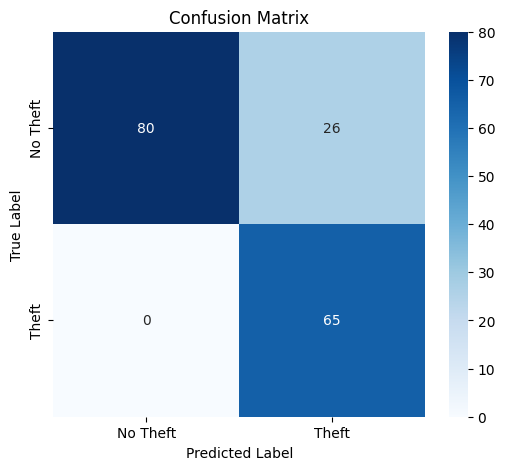

In [69]:
# Evaluate on validation set
evaluate_model(model, test_loader, device=device, class_names=["No Theft", "Theft"])

In [70]:
video_path = "/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters/shop_lifter_n_106_1.mp4"
predict_single_video(trained_model, video_path, device=device, class_names=["No Theft", "Theft"])


  🎬 Video Prediction  
        Result         
┏━━━━━━━┳━━━━━━━━━━━━━┓
┃ Class ┃ Probability ┃
┡━━━━━━━╇━━━━━━━━━━━━━┩
│ Theft │   68.22%    │
└───────┴─────────────┘

Inference Time: 0.0203 seconds

In [61]:
video_path = "/kaggle/input/anti-theft-dataset/Shop DataSet/shop lifters/shop_lifter_118.mp4"
predict_single_video(trained_model, video_path, device=device, class_names=["No Theft", "Theft"])


  🎬 Video Prediction  
        Result         
┏━━━━━━━┳━━━━━━━━━━━━━┓
┃ Class ┃ Probability ┃
┡━━━━━━━╇━━━━━━━━━━━━━┩
│ Theft │   71.32%    │
└───────┴─────────────┘

Inference Time: 0.0406 seconds

In [ ]:
# yolo, prunning , quantization, teacher-student, 